In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
# from sqlalchemy import create_engine, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

inspector = inspect(engine)

inspector.get_table_names()

['measurement', 'station']

In [7]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
measurement = Base.classes.measurement

station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date = session.query(measurement.date).\
    order_by(measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database (2017-08-23)
query_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
query_date

datetime.date(2016, 8, 23)

In [13]:
results = session.query(measurement.date, measurement.prcp).\
                   filter(measurement.date >= query_date).all()

<AxesSubplot:xlabel='Date'>

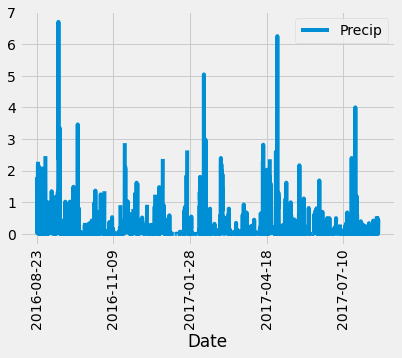

In [14]:
bar_df = pd.DataFrame(results, columns=['Date', 'Precip'])
bar_df.set_index(bar_df['Date'], inplace=True)

# Sort the dataframe by date
bar_df = bar_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
bar_df.plot(rot=90)

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
bar_df.describe()

,Precip
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
rows = session.query(measurement)
stations = []
for row in rows:
        stations.append(row.station)
num_stations = len(set(stations))
total = len(stations)
print(f"There are {num_stations} unique stations and {total} total station entries in this dataset")

There are 9 unique stations and 19550 total station entries in this dataset


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(measurement.station, func.count(measurement.station))\
.group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()


print(most_active)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min = session.query(func.min(measurement.tobs)).filter(measurement.station == "USC00519281").first()
max = session.query(func.max(measurement.tobs)).filter(measurement.station == "USC00519281").first()
avg = session.query(func.avg(measurement.tobs)).filter(measurement.station == "USC00519281").first()

print(f"The minimum temperature is {min[0]} degrees")
print(f"The maximum temperature is {max[0]} degrees")
print(f"The average temperature is {avg[0]} degrees")

The minimum temperature is 54.0 degrees
The maximum temperature is 85.0 degrees
The average temperature is 71.66378066378067 degrees


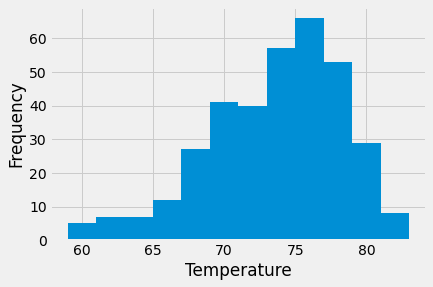

In [19]:
# Choose the station with the highest number of temperature observations.
temp_data = session.query(measurement.date,measurement.tobs).\
                  filter(measurement.date >= query_date).filter(measurement.station == "USC00519281").order_by(measurement.tobs.desc()).all()

temp_rows = [{"Date": temp[0], "Temp": temp[1] } for temp in temp_data]
temp_df = pd.DataFrame(temp_rows)


# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(temp_df['Temp'], bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
